# Stock Price Prediction with LSTM

Adapted from "[Stock Price Prediction with PyTorch](https://medium.com/swlh/stock-price-prediction-with-pytorch-37f52ae84632)" by Rodolfo Saldanha (original code available [here](https://www.kaggle.com/code/rodsaldanha/stock-prediction-pytorch/notebook))

In [1]:
import time
import math
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import plotly.express as px

## Import data and preprocessing

In [2]:
data = pd.read_csv('data/AMZN_l1y.csv')
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-02-18,155.499496,155.499496,150.893005,152.601501,152.601501,63604000
1,2022-02-22,150.478500,152.982498,148.485504,150.197495,150.197495,66128000
2,2022-02-23,151.650497,151.763000,144.651001,144.826996,144.826996,64244000
3,2022-02-24,139.837494,151.748993,139.500000,151.358002,151.358002,100786000
4,2022-02-25,150.550003,153.990005,149.213501,153.788498,153.788498,62396000
...,...,...,...,...,...,...,...
246,2023-02-13,97.849998,99.680000,96.910004,99.540001,99.540001,52841500
247,2023-02-14,98.410004,100.919998,97.519997,99.699997,99.699997,56202900
248,2023-02-15,99.089996,101.169998,98.449997,101.160004,101.160004,48053900
249,2023-02-16,99.209999,100.629997,98.099998,98.150002,98.150002,56339200


In [3]:
price = data[['Close']].copy()
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))
price

,Close
0,0.617955
1,0.563003
2,0.440242
3,0.589531
4,0.645088
...,...
246,-0.594948
247,-0.591291
248,-0.557918
249,-0.626721


In [4]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback + 1): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]
lookback = 10 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)

## Set up LSTM

In [5]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [6]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

In [7]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [8]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

## Train LSTM

In [9]:
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.2266177088022232
Epoch  1 MSE:  0.21580535173416138
Epoch  2 MSE:  0.204065203666687
Epoch  3 MSE:  0.1886574625968933
Epoch  4 MSE:  0.16499590873718262
Epoch  5 MSE:  0.1220073327422142
Epoch  6 MSE:  0.06098898500204086
Epoch  7 MSE:  0.05686047673225403
Epoch  8 MSE:  0.1342545598745346
Epoch  9 MSE:  0.06068352237343788
Epoch  10 MSE:  0.04848083108663559
Epoch  11 MSE:  0.05319572612643242
Epoch  12 MSE:  0.05959492176771164
Epoch  13 MSE:  0.06644424796104431
Epoch  14 MSE:  0.07014933973550797
Epoch  15 MSE:  0.06846250593662262
Epoch  16 MSE:  0.06101777404546738
Epoch  17 MSE:  0.049610987305641174
Epoch  18 MSE:  0.03887145221233368
Epoch  19 MSE:  0.0353088453412056
Epoch  20 MSE:  0.040592726320028305
Epoch  21 MSE:  0.04525907337665558
Epoch  22 MSE:  0.043675996363162994
Epoch  23 MSE:  0.040898073464632034
Epoch  24 MSE:  0.03853091225028038
Epoch  25 MSE:  0.03517938405275345
Epoch  26 MSE:  0.032272759824991226
Epoch  27 MSE:  0.03180708736181259
Epoc

In [10]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

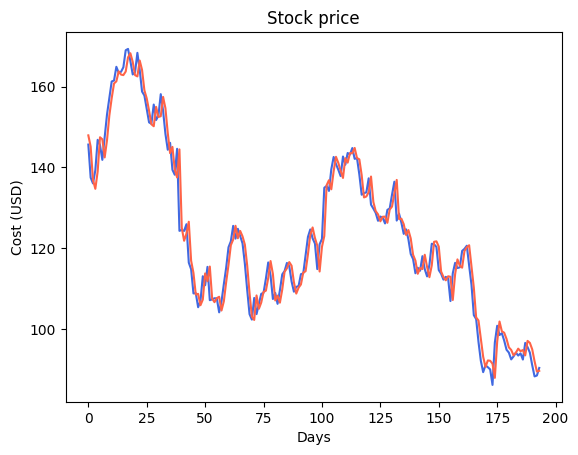

In [11]:
plt.plot(original.index, original[0], label="Data", color='royalblue')
plt.plot(predict.index, predict[0], label="Training Prediction (LSTM)", color='tomato')
plt.title('Stock price')
plt.xlabel("Days")
plt.ylabel("Cost (USD)")
plt.show()

## Predict

In [12]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 3.92 RMSE
Test Score: 2.65 RMSE


## Results

In [13]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback-1:len(y_train_pred)+lookback-1, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price), :] = y_test_pred

original = scaler.inverse_transform(price['Close'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [14]:
result.tail(60)

,0,1,2
191,93.477638,NaN,93.199997
192,94.106651,NaN,94.129997
193,95.114799,NaN,93.410004
194,94.483810,NaN,93.949997
195,94.780029,NaN,92.419998
196,93.451012,NaN,96.540001
197,97.040382,NaN,95.500000
198,96.541412,NaN,94.129997
199,94.943947,NaN,91.010002
200,92.000534,NaN,88.250000


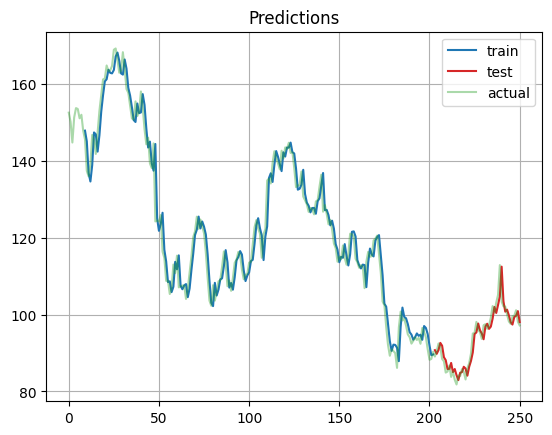

In [15]:
plt.plot(result.index, result[0], color="tab:blue", label="train")
plt.plot(result.index, result[1], color="tab:red", label="test")
plt.plot(result.index, result[2], color="tab:green", alpha=0.4, label="actual")
plt.legend()
plt.title("Predictions")
plt.grid()
plt.show()

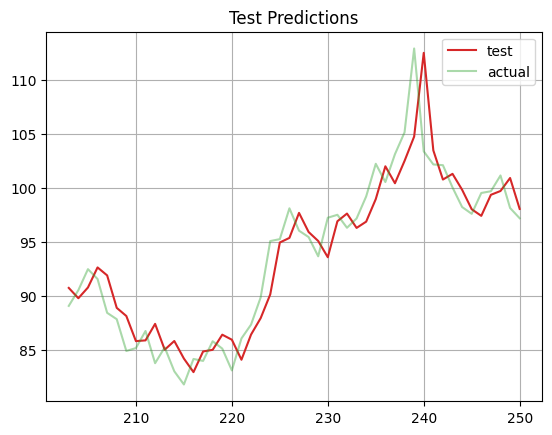

In [16]:
plt.plot(result.index[-y_test.shape[0]:], result[1][-y_test.shape[0]:], color="tab:red", label="test")
plt.plot(result.index[-y_test.shape[0]:], result[2][-y_test.shape[0]:], color="tab:green", alpha=0.4, label="actual")
plt.legend()
plt.title("Test Predictions")
plt.grid()
plt.show()

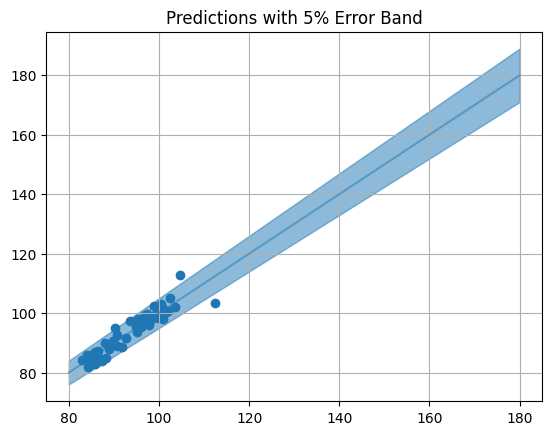

In [17]:
plt.scatter(y_test_pred, y_test)

x = np.linspace(80, 180, 300)
y = np.linspace(80, 180, 300)
error = 0.05 * x

plt.plot(x, y, alpha=0.5)
plt.fill_between(x, y-error, y+error, color="tab:blue", alpha=0.5)
plt.title("Predictions with 5% Error Band")
plt.grid()
plt.show()

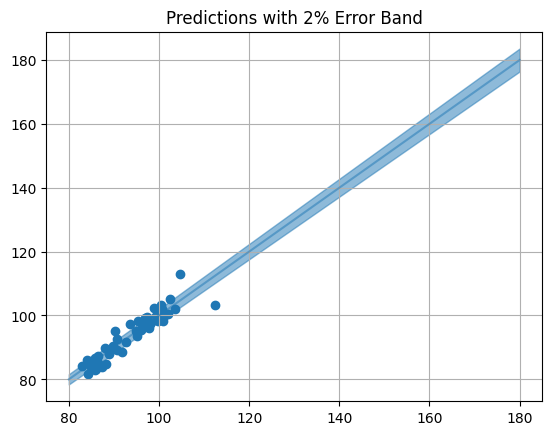

In [18]:
plt.scatter(y_test_pred, y_test)

x = np.linspace(80, 180, 300)
y = np.linspace(80, 180, 300)
error = 0.02 * x

plt.plot(x, y, alpha=0.5)
plt.fill_between(x, y-error, y+error, color="tab:blue", alpha=0.5)
plt.title("Predictions with 2% Error Band")
plt.grid()
plt.show()

## Benchmark
The benchmark histogram displays the distribution of probabilities that the LSTM can predict more accurately than a randomly picked value from normal distribution with mean `loc` and variance `scale` (i.e. the random walk model). 

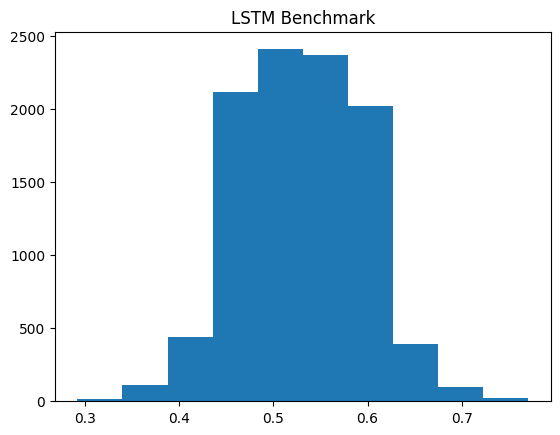

In [19]:
def benchmark(iterations=10000, loc=0, scale=0.01):
    
    b_score_list = []
    for _ in np.arange(iterations):
        x_rand = original[-y_test.shape[0]-1:-1] * (1 + np.random.normal(loc, scale, size=y_test.shape))
        b_score = np.mean(np.abs(y_test_pred - y_test).flatten() < np.abs(x_rand - y_test).flatten())
        b_score_list.append(b_score)
    
    plt.hist(b_score_list)
    plt.title("LSTM Benchmark")

benchmark()

https://stats.stackexchange.com/questions/576989/how-to-minimize-prediction-lag-using-lstm-model: 

This is not a problem with LSTM, it is a problem with your target variable. If this is the S&P 500 index, you are trying to predict a largely unpredictable time series. Your best bet is a random walk model for the logarithm of the index, $y_t=y_{t−1}+\varepsilon t$
 where $y_t:=\log(x_t)$
 with $x_t$
 being the index value at time t
. (You could add a drift term to the random walk, but that would not make a big difference for one-day-ahead forecasting.) An optimal point forecast under square loss is $\hat{y}_{t+1}|y_t=y_t$
 which lags the actual, unknown value $y_{t+1}$
 by one day. Your LSTM is trying to approximate this underlying reality.

(LSTM may beat the random walk model in sample or even on a test sample if you retune the model and let it predict the same test sample multiple times and then pick the best case. However, it is not likely to beat the random walk model truly our of sample where it only gets one go at it without retuning.)